In [11]:
# pip install pydot

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG16
from sklearn.metrics import *
import tensorflow.keras.backend as K
import os
import seaborn as sr
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import *
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
from tqdm import tqdm
from tensorflow.keras import layers
# from tensorflow.keras.layers import 
from tensorflow.keras.callbacks import *
from tensorflow.keras import *
from Custom_Image_generator import *
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings("ignore")
from PCA_pooling import pca,pca_mean

In [13]:
model_path = "/media/kashraf/Elements/Dissertation/modelling/hyperopt/Wavelet_based/theta/weights"
base_model = load_model(os.path.join(model_path,"f606b_theta_interv1_V1.h5"),custom_objects={"tf":tf})
base_model.summary()

for layer in base_model.layers[:-17]:
    layer.trainable = False
x = base_model.layers[-7].output
x = Conv2D(128, (5, 5),kernel_regularizer=regularizers.l2(0.01),name="Added_conv")(x)
x = BatchNormalization(name="Added_batch_norm")(x)
x = Activation('relu',name="added_relu")(x)
x = pca(1)(x)
x = Flatten()(x)
base_model = Model(inputs=base_model.input, outputs=x)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 148, 148, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 148, 148, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 148, 148, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 148, 148, 51) 20451       conv2d[0][0]                     
______________________________________________________________________________________________

### Data Generator

In [14]:
def get_img_label(path,interval,keyword="train"):
    paths = []
    cl2_files = os.listdir ( os.path.join(path, "interv"+str(interval),keyword,"cl2"))
    cl2_files = [os.path.join(path, "interv"+str(interval),keyword,"cl2",file) 
               for file in cl2_files]
    
    cl4_files = os.listdir ( os.path.join(path, "interv"+str(interval),
                                          keyword,"cl4"))
    cl4_files = [os.path.join(path, "interv"+str(interval),
                        keyword,"cl4",file) for file in cl4_files]

    cl6_files = os.listdir ( os.path.join(path, "interv"+str(interval),
                                          keyword,"cl6"))
    cl6_files = [os.path.join(path, "interv"+str(interval),keyword,"cl6",
                              file) for file in cl6_files]
    
  
    cl8_files = os.listdir ( os.path.join(path, 
                                "interv"+str(interval),keyword,"cl8"))
    cl8_files = [os.path.join(path, 
        "interv"+str(interval),keyword,"cl8",file) for file in cl8_files]
    
    int_files = [cl2_files,cl4_files,cl6_files,cl8_files]
    
    paths +=int_files
    
    labels = [[0]*len(cl2_files),[1]*len(cl4_files),
            [2]*len(cl6_files),[3]*len(cl8_files)]
    
 
    return np.concatenate(paths),np.concatenate(labels)

In [15]:
path = "/media/kashraf/Elements/Dissertation/data/preprocessed/audio/stack/"

In [16]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, x_fnames,y_fnames,batch_size,target_size=(148, 148, 3),shuffle=True):
        
        self.x_fnames = x_fnames
        self.y_fnames = y_fnames
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()
       
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.x_fnames[0].shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __process_batch(self,batch_files):
        interval_images = []
        for file in batch_files:
            image = tf.keras.preprocessing.image.load_img(file)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            image_arr = tf.image.resize(image_arr,(self.target_size[0], self.target_size[1])).numpy()
            interval_images.append(image_arr/255)
        return interval_images
  
    
    def __get_data(self,batch_indexes):
        
        files = self.x_fnames
        
        # Select batch files and labels from all files 
        batch_files = [file[batch_indexes] for file in files] 
        
        batch_images = [np.array(self.__process_batch (batch)) 
                        for batch in batch_files]
        
        batch_labels = self.y_fnames[batch_indexes]
        batch_labels = to_categorical(batch_labels,num_classes=4)
        
        return batch_images,batch_labels

    
    def __getitem__(self, index):
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        x, y = self.__get_data(indexes)        
        return x, y
    
    def __len__(self):
        return int(np.floor(self.x_fnames[0].shape[0]) / self.batch_size)


In [17]:
x_train_files = [get_img_label (path, interv,keyword="train")[0] for interv in range(1,8)]
y_train_files = get_img_label (path,1,keyword="train")[1]

x_test_files = [get_img_label (path, interv,keyword="test")[0] for interv in range(1,8)]
y_test_files =get_img_label (path,1,keyword="test")[1]

train_gen = CustomDataGen(x_train_files,y_train_files,batch_size=8)
test_gen  = CustomDataGen(x_test_files,y_test_files,batch_size=8,shuffle=False)


### Modelling

### PCA layer

### Patch encoder

In [18]:
class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding':self.position_embedding
        })
        return config
    @tf.function
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Feed forward block

In [19]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Hyperparameter setup

In [20]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
# Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers 
#of the final classifier


#### CNN block

In [21]:
img_shape = (148,148,3)
def get_model(shape):
    inputs=Input(shape=shape)
    
    # First conv layer
    x = Conv2D(32, (7, 7), padding="same",kernel_regularizer=l2(0.01))(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    
     # Second conv layer
    x = Conv2D(64, (5, 5), padding = "same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(32, (5, 5), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   
    
    x = Conv2D(96, (3, 3), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
   
    
    x = Conv2D(96, (3, 3), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, (3, 3), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    
    x = pca()(x)
    outputs= Flatten()(x)
    return Model(inputs, outputs)

def create_EEG_transformer():

    models = [base_model]*7
    input1 = Input(shape=img_shape,name="int_1")
    input2 = Input(shape=img_shape,name="int_2")
    input3 = Input(shape=img_shape,name="int_3")
    input4 = Input(shape=img_shape,name="int_4")
    input5 = Input(shape=img_shape,name="int_5")
    input6 = Input(shape=img_shape,name="int_6")
    input7 = Input(shape=img_shape,name="int_7")
    inputs = [input1,input2,input3,input4,input5,input6,input7]
    
    # Extract output of CNN models and stack them
    ys=[models[i](inputs[i]) for i in range(len(inputs))]
    ys= tf.stack(ys,axis=1)
    
    # Call path encoder and add position encoding
    encoded_patches = PatchEncoder(num_patches =7, projection_dim=projection_dim)(ys)
    
    # Add multihead Attention block
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        
        # OG drouout was 0.1
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.3
        )(x1, x1)
        
        # Skip connection 1.
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        # OG drouout was 0.1
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.4)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = Dense(4,activation="softmax",name="class")(features)
    # Create the Keras model.
    model = Model(inputs=inputs, outputs=logits)
    model.compile(loss = 'categorical_crossentropy',
              optimizer = Adagrad(),
              metrics = ['accuracy'])
    
    return model
    
    
    
    


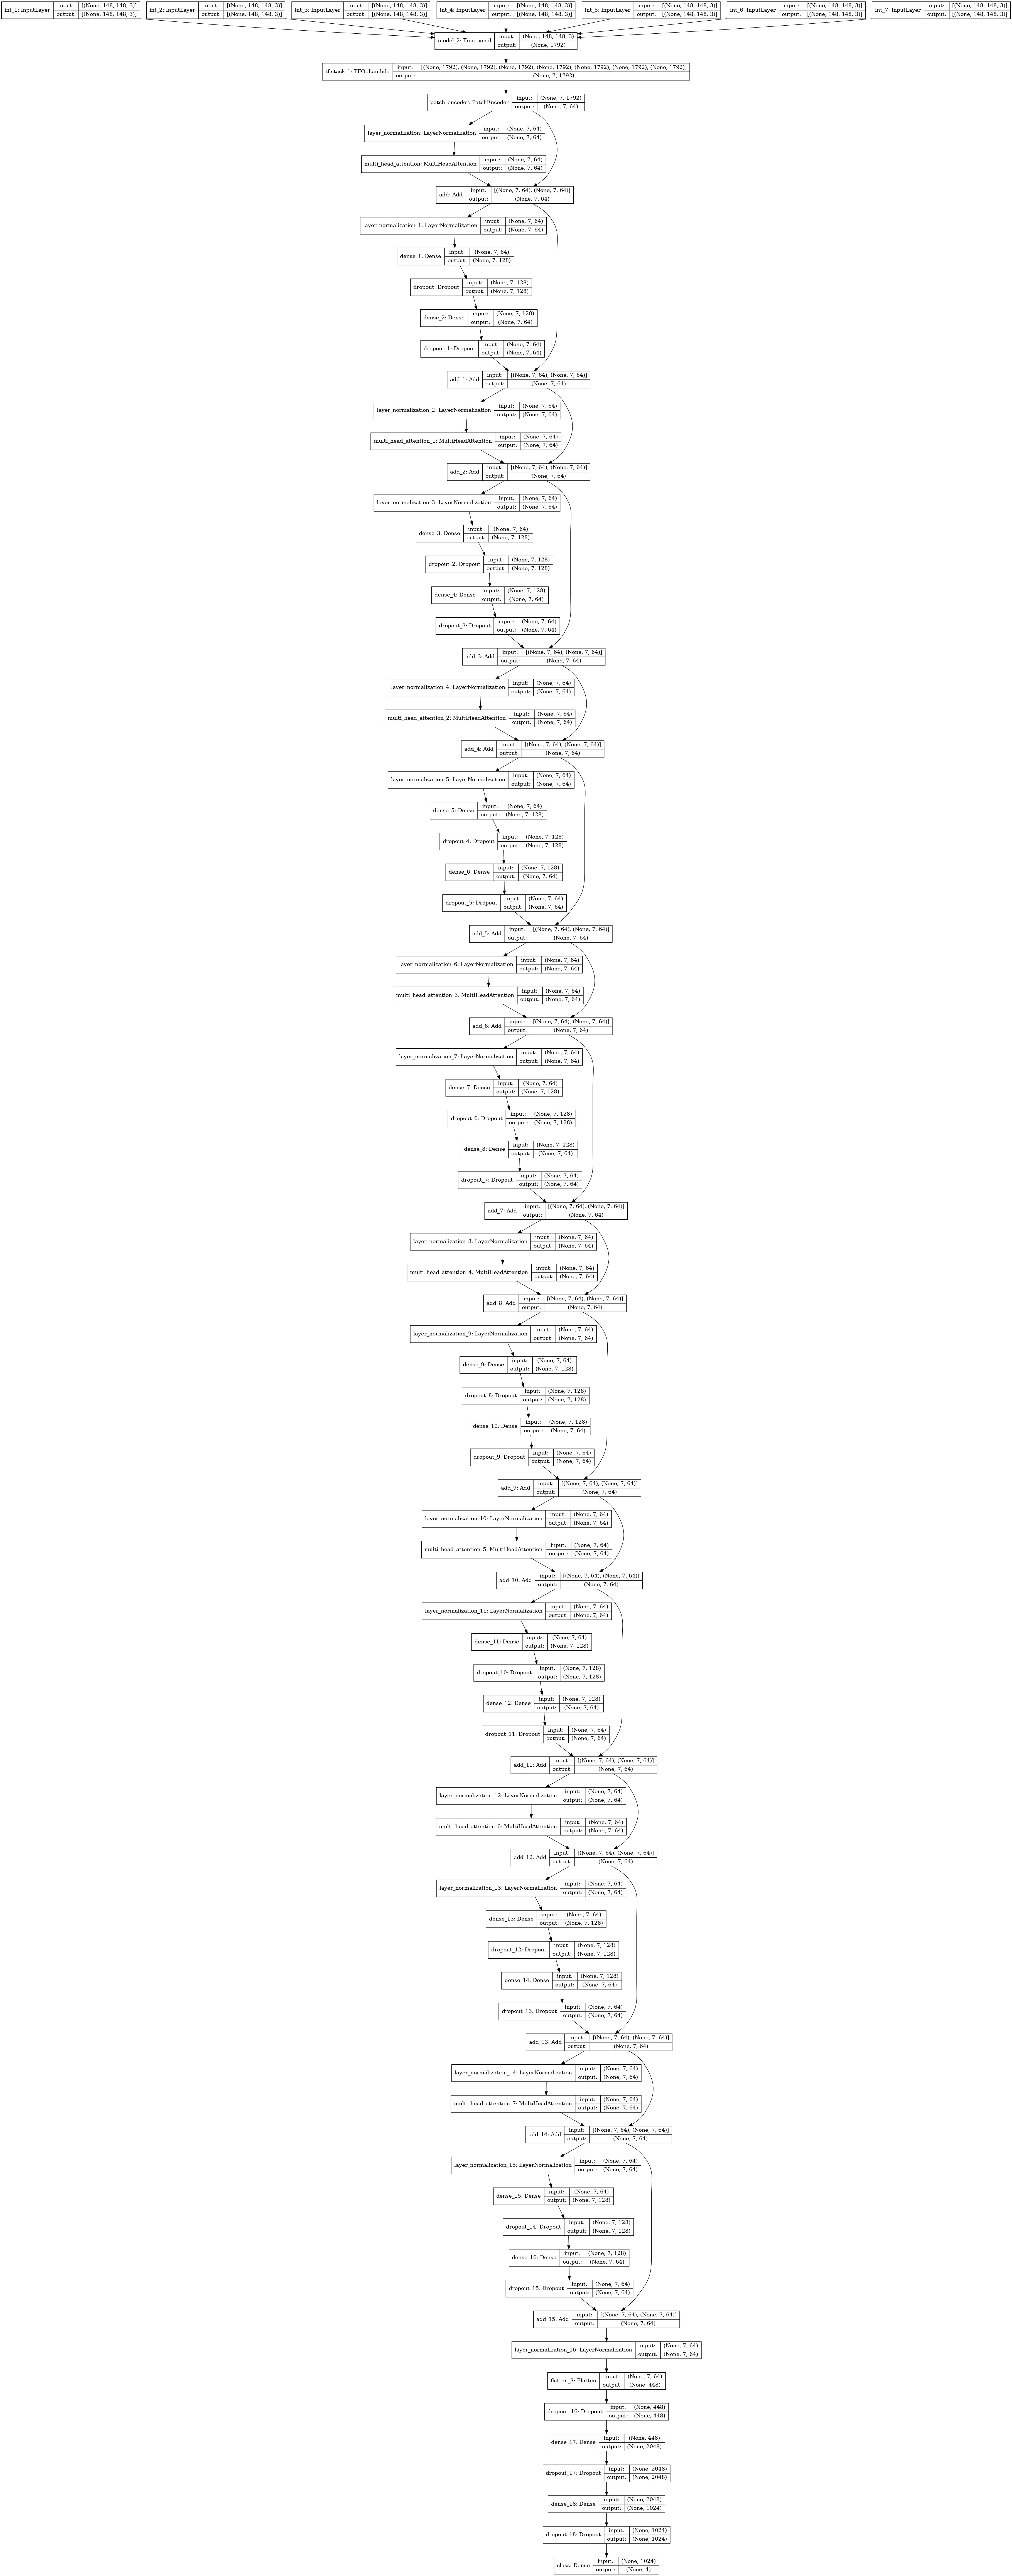

In [22]:
res_dir = "/media/kashraf/Elements/Dissertation/modelling/General/results"
model=create_EEG_transformer()
plot_model(model,show_shapes=True,to_file= os.path.join(res_dir,"EEG_Transfromer_stack_interv.png"))
# model.summary()


### Training

In [ ]:
weight_dir = "/media/kashraf/Elements/Dissertation/modelling/General/weights/"            
checkpoint = ModelCheckpoint(os.path.join(weight_dir,"MIMO_transformer_stack.h5"),
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.000001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr,earlystop]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adagrad(),
              metrics = ['accuracy'])


epochs = 100

history= model.fit(train_gen,validation_data=test_gen,
    epochs=100,callbacks=callbacks
)

2022-12-14 11:04:50.381020: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-14 11:04:50.398471: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/100


2022-12-14 11:04:58.006324: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-14 11:04:58.250905: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1925/1925 [==============================] - 748s 384ms/step - loss: 3.5756 - accuracy: 0.2663 - val_loss: 3.1674 - val_accuracy: 0.2891

Epoch 00001: val_loss improved from inf to 3.16740, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/MIMO_transformer_stack.h5
Epoch 2/100
1925/1925 [==============================] - 607s 315ms/step - loss: 3.1897 - accuracy: 0.2700 - val_loss: 2.9494 - val_accuracy: 0.3445

Epoch 00002: val_loss improved from 3.16740 to 2.94938, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/MIMO_transformer_stack.h5
Epoch 3/100
1925/1925 [==============================] - 629s 327ms/step - loss: 2.9686 - accuracy: 0.2749 - val_loss: 2.7705 - val_accuracy: 0.3141

Epoch 00003: val_loss improved from 2.94938 to 2.77048, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/MIMO_transformer_stack.h5
Epoch 4/100
1925/1925 [==============================] - 649s 337ms/step - loss: 2.

1925/1925 [==============================] - 618s 321ms/step - loss: 1.0642 - accuracy: 0.9000 - val_loss: 1.0725 - val_accuracy: 0.8927

Epoch 00029: val_loss did not improve from 1.04373
Epoch 30/100
1925/1925 [==============================] - 621s 323ms/step - loss: 1.0452 - accuracy: 0.9069 - val_loss: 1.0171 - val_accuracy: 0.9138

Epoch 00030: val_loss improved from 1.04373 to 1.01713, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/MIMO_transformer_stack.h5
Epoch 31/100
1925/1925 [==============================] - 652s 339ms/step - loss: 1.0334 - accuracy: 0.9079 - val_loss: 1.0224 - val_accuracy: 0.9123

Epoch 00031: val_loss did not improve from 1.01713
Epoch 32/100
1925/1925 [==============================] - 649s 337ms/step - loss: 1.0275 - accuracy: 0.9103 - val_loss: 1.0024 - val_accuracy: 0.9161

Epoch 00032: val_loss improved from 1.01713 to 1.00238, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/MIMO_transf

In [ ]:
import pickle
result_path = "/media/kashraf/Elements/Dissertation/modelling/General/results/MIMO_transformer/stack/"

pickle.dump(history.history, open(os.path.join(result_path,"history_MIMO_transformer_stack.pkl"), 'wb'))
history =history.history

## Loss curves

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(15,7))
plt.xticks(fontsize=13,weight="bold")
plt.yticks(fontsize=13,weight="bold")
loss_values = history['loss']
val_loss_values = history['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=3.0,marker = '+', markersize=10.0)
plt.setp(line2, linewidth=3.0,marker = '4', markersize=10.0)
plt.xlabel('Epochs',fontsize=20,weight="bold") 
plt.ylabel('Loss',fontsize=20,weight="bold")
plt.grid(True)
plt.xticks(fontsize=15,weight="bold")
plt.yticks(fontsize=15,weight="bold")
plt.legend(fontsize=20,loc = "upper center")
plt.savefig(result_path+'MIMO_transformer_stack_Loss.png',bbox_inches ="tight",pad_inches =0)
plt.show()


## Accuracy curves

### Performance Analysis

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(15,7))
plt.xticks(fontsize=13,weight="bold")
plt.yticks(fontsize=13,weight="bold")
acc_values = history['accuracy']
val_acc_values = history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation Accuracy')
line2 = plt.plot(epochs, acc_values , label='Training Accuracy')
plt.setp(line1, linewidth=3.0,marker = '+', markersize=10.0)
plt.setp(line2, linewidth=3.0,marker = '4', markersize=10.0)
plt.xlabel('Epochs',fontsize=20,weight="bold") 
plt.ylabel('Loss',fontsize=20,weight="bold")
plt.grid(True)
plt.xticks(fontsize=15,weight="bold")
plt.yticks(fontsize=15,weight="bold")
plt.legend(fontsize=20,loc= "lower center")
plt.savefig(result_path+'MIMO_transformer_stack_Accuracy.png',bbox_inches ="tight",pad_inches =0)
plt.show()


## Confusion matrices

In [ ]:
# Confusion Matrix¶
import seaborn as sr
import pandas as pd
test_gen  = CustomDataGen(x_test_files,y_test_files,batch_size=8,shuffle=False)
y_pred= np.argmax(model.predict(test_gen), axis=1)
y_test= test_gen.y_fnames

plt.style.use("ggplot")
# y_predict,distances1=  face_recognition(x_test_recog,T_distance)
# accuracy=accuracy_score(y_test_recog,y_predict)
class_names=["CL_1","CL_2","CL_3","CL_4"]
report=classification_report(y_test,y_pred,target_names=class_names)
np.save(result_path+"MIMO_transformer_theta_report.npy",report)

conf=confusion_matrix(y_test,y_pred,normalize="true")
conf_df=pd.DataFrame(conf, index=class_names, columns=class_names)
# print("\nFace  accuracy =",accuracy)
print("\n Classification report: \n",report)
fig=plt.figure(figsize=(15,10))
sr.heatmap(conf_df,annot=True,cmap="Blues")
# plt.title("Confusion matrix")
plt.savefig(result_path+"MIMO_transformer_stack_conf_mat.png")
plt.show()
